In [25]:
# Config Variables

# Testing Data
X = [[1,1], [1,-2], [-2,1]]
y = [1, 4, -5]
ols_coefficients = [1, 1]

# Config Variables

# Define UCI Datasets to pull
# https://archive.ics.uci.edu/ml/datasets.php
uci_datasets = [1]

# Use all data (vs just training data) for OLS to determine co-efficient sign
ols_use_all_data = False

# Training set sizes to use (only training set sizes < 60% of total dataset size will be used)
#training_set_sizes = [10, 40, 160, 640, 2560, 10240, 40960]
training_set_sizes = [3]
chain_lengths = [20000, 20000, 100000, 100000, 100000, 100000, 100000]

# Number of etas (prior standard deviation) to test between 1e-04 and 1e05 (recommend 20)
# Limits at 0 and infinity are calculated separately
# Note: In practice, sigma^2 (likelihood variance) is set to 1/eta^2 and
#       lambda (penalty) is set to 1/eta^4 
num_etas = 20

# Number of folds for cross-validation (set to 300 in 2018 paper, recommend testing with 20)
cv_folds = 1

# Overwrite model if it's already saved to file
overwrite_model = True

In [7]:
# Load necessary libraries and helper functions

# import half_ridge functions from helpers/half_ridge.py
#from helpers.half_ridge import *

# import testing functions from helpers/testing_functions.py
from helpers.testing_functions import *

# import dataset class
from helpers.model import Model

# import os and pickle
import os
import pickle
 
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

import time

# PyMC for Bayesian Inference
import pymc as pm

# Import scipy stats
from scipy.linalg import pinv, eigh
from scipy.stats import multivariate_normal


# Matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import FuncFormatter
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

In [18]:

# Use rejection sampling to fit a half-ridge regression model to the data
def half_ridge_rejection_sampling(weight_signs, ols_coefficients, X_train, y_train, prior_eta, chain_length):
    print('Running half-ridge regression...')

    if(prior_eta == 0):
        # Create post_weights array with the same magnitude but with signs of ols_coefficients
        value = np.sqrt(2 / np.pi) # From 2018 Paper
        post_weights = weight_signs * value 
        post_weights = dict(zip(X_train.columns, post_weights))
        return post_weights
    elif(prior_eta == np.inf):
        # Simple OLS at the limit
        # @todo - need to use euclidean projection into correct quadrant if the signs don't match!
        
        return ols_coefficients


    # assumption that cue directionalities are known in advance (Dawes, 1979)
    col_pos = (weight_signs > 0).astype(int)
    total_features = len(ols_coefficients)

    # Set penalty (lambda = sigma^2/eta^2) and sigma^2 (sigma = 1/eta)
    sigma_2 = 1/(prior_eta ** 2)
    penalty = 1/(prior_eta ** 4)

    # Convert pandas dataframe to arrays
    X = X_train.values
    Y = y_train.values
    
    ### L2 half-ridge Fitting (Training Data) ###
    #inter = pinv(np.dot(X.T, X) + penalty * np.eye(total_features))

    # posterior mean is a vector that is total_features-dimensional, as a function of penalty
    post_mean = np.dot(pinv(penalty * np.eye(total_features) + np.dot(X.T, X)), np.dot(X.T, Y))
    
    # posterior variance is a total_features x total_features covariance square matrix
    post_var = pinv(sigma_2 * np.eye(total_features) + (1/sigma_2)* np.dot(X.T, X))
    #post_var = sigma_2 * inter
    
    # Ensure the posterior variance matrix is positive-definite
    if not is_positive_definite(post_var):
        post_var = nearest_posdef(post_var)
    
    # Sampling from a multivariate Gaussian with above mean and variance
    samples1 = multivariate_normal.rvs(mean=post_mean, cov=post_var, size=chain_length)

    # Plot the samples
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.scatter(samples1[:, 0], samples1[:, 1], alpha=0.5)
    ax.set_xlabel('Weight 1')
    ax.set_ylabel('Weight 2')
    ax.set_title('Posterior Weights from Half-Ridge Regression')
    plt.show()

    # Identify the column indices for positive and negative weights
    positive_indices = np.where(col_pos == 1)[0]
    negative_indices = np.where(col_pos == 0)[0]

    # Cut-off rule: reflects the correct cue directions that are known in advance (ols_coefficients)
    # Find rows with features that have an incorrect sign
    incorrect_positive = np.any(samples1[:, positive_indices] < 0, axis=1)
    incorrect_negative = np.any(samples1[:, negative_indices] > 0, axis=1)
    incorrect_signs = incorrect_positive | incorrect_negative

    # Set the entire row to NaN where any incorrect value is found
    samples1[incorrect_signs, :] = np.nan


    # Plot the samples
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.scatter(samples1[:, 0], samples1[:, 1], alpha=0.5)
    ax.set_xlabel('Weight 1')
    ax.set_ylabel('Weight 2')
    ax.set_title('Posterior Weights 2 from Half-Ridge Regression')
    plt.show()
    
    # Calculate the posterior weights
    post_weights = np.nanmean(samples1, axis=0)
    
    # If all samples are NaN, retry sampling
    i = 0
    while np.isnan(post_weights).any() and i < 3:
        i += 1
        samples1 = multivariate_normal.rvs(mean=post_mean, cov=post_var, size=50000)
        samples1[:, col_pos == 1][samples1[:, col_pos == 1] < 0] = np.nan
        samples1[:, col_pos == 0][samples1[:, col_pos == 0] > 0] = np.nan
        post_weights = np.nanmean(samples1, axis=0)
    
    if np.isnan(post_weights).any():
        raise ValueError('NA error in posterior weights')
    
    # Convert post_weights to a dictionary with appropriate column names
    post_weights = dict(zip(X_train.columns, post_weights))
    
    return post_weights


# Find the nearest positive-definite matrix to a given matrix
def nearest_posdef(A):
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    H = np.dot(V.T, np.dot(np.diag(s), V))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    if is_positive_definite(A3):
        return A3
    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not is_positive_definite(A3):
        mineig = np.min(np.real(eigh(A3)[0]))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    return A3


# Check if a matrix is positive definite
def is_positive_definite(x):
    return np.all(np.linalg.eigvals(x) > 0)



In [4]:
# Convert to dataframes
X = pd.DataFrame(X, columns=['Column1', 'Column2'])
y = pd.DataFrame(y)

# Get weight signs
weight_signs = np.sign(ols_coefficients)

# Initialize the comparison results
binary_comparisons = {}

# Vary eta values from 10^-4 to 10^5, including 0 and inf, and loop over them
etas = np.logspace(-4, 5, num=num_etas)
etas = np.insert(etas, 0, 0)
etas = np.append(etas, np.inf)
for eta in etas:

    # Initialize the comparison results for this eta
    binary_comparisons[eta] = []

    # Crossvalidate over the folds for a specific eta
    for i in range(cv_folds):

        half_ridge_coefficients = half_ridge_rejection_sampling(weight_signs, ols_coefficients, X, y, eta, 20000)

        # Calculate the binary comparisons for the models
        sorted_half_ridge_coefficients = {k: half_ridge_coefficients[k] for k in sorted(half_ridge_coefficients)}
        sorted_half_ridge_coefficients['intercept'] = 0
        print('half-ridge coefficients')
        print(sorted_half_ridge_coefficients)
        binary_comparison = calculate_binary_comparison(sorted_half_ridge_coefficients, X, y)
        binary_comparisons[eta].append(binary_comparison)
        print('binary comparisons')
        print(binary_comparison)   


Running half-ridge regression...
half-ridge coefficients
{'Column1': 0.7978845608028654, 'Column2': 0.7978845608028654, 'intercept': 0}


KeyError: 1

Training Set Values: [3]
Training Set Value: 3, Eta: 0.0, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...
Half ridge regression rejection sampling took 2.193450927734375e-05 seconds
half-ridge coefficients: {'Column1': 0.7978845608028654, 'Column2': 0.7978845608028654, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 0.0001, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


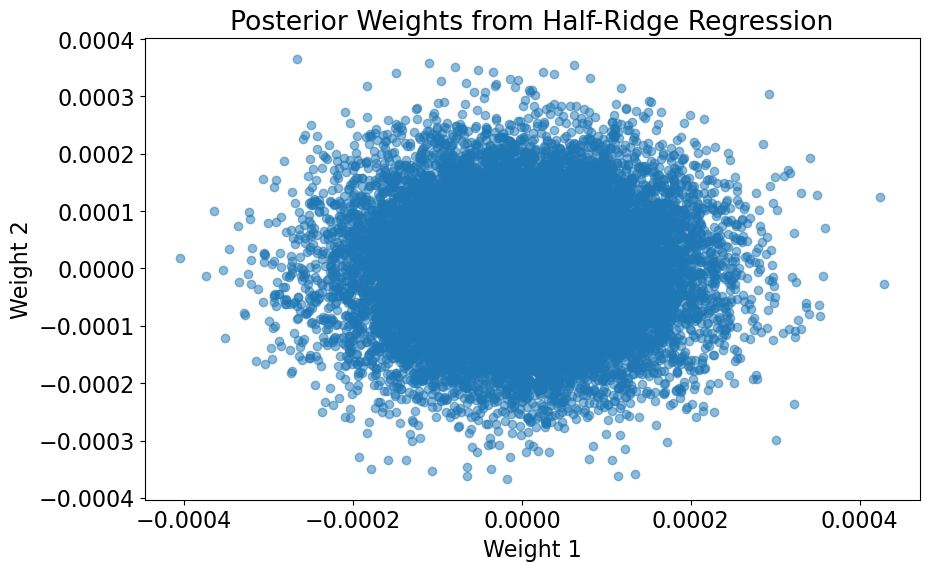

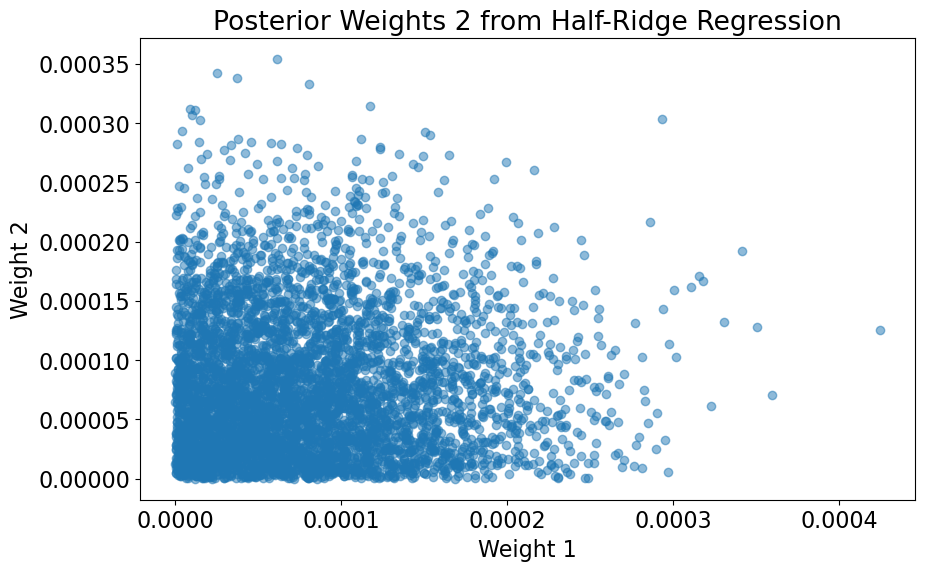

Half ridge regression rejection sampling took 0.19533991813659668 seconds
half-ridge coefficients: {'Column1': 7.97552248629939e-05, 'Column2': 7.82292070272383e-05, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 0.00029763514416313193, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


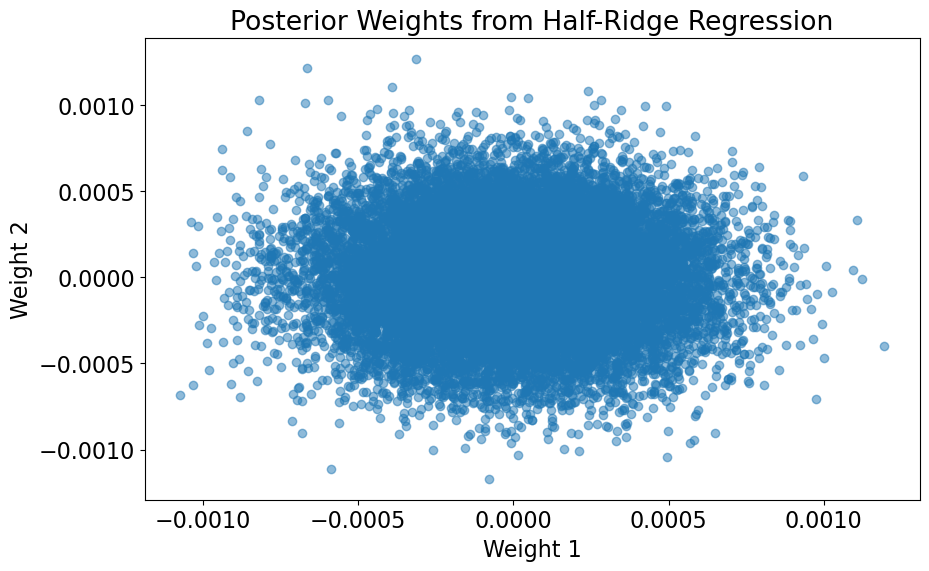

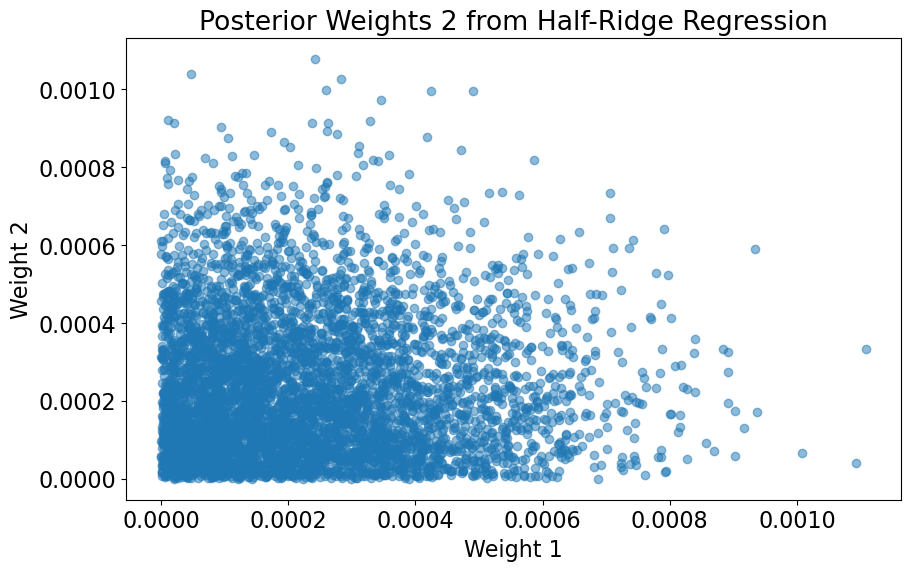

Half ridge regression rejection sampling took 0.143049955368042 seconds
half-ridge coefficients: {'Column1': 0.00023369744044151726, 'Column2': 0.00023579702959883577, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 0.0008858667904100823, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


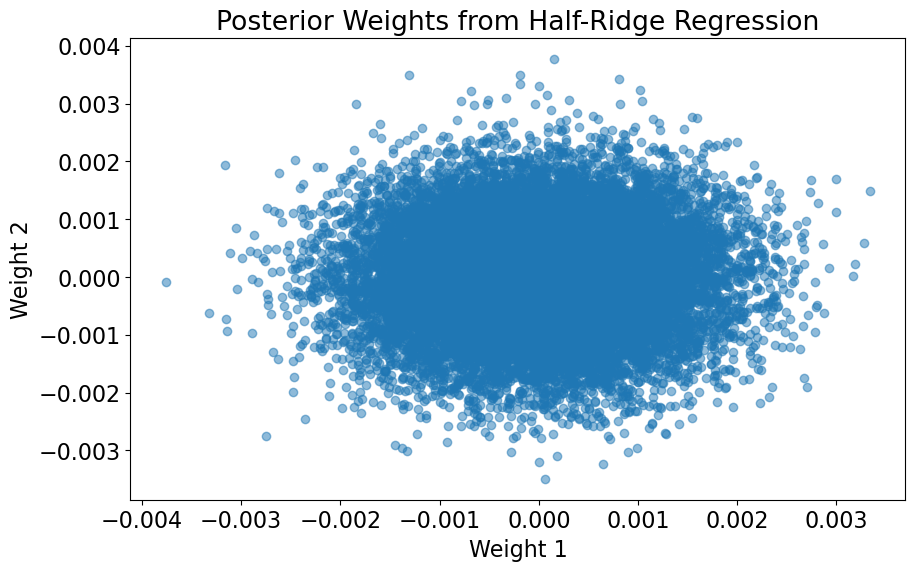

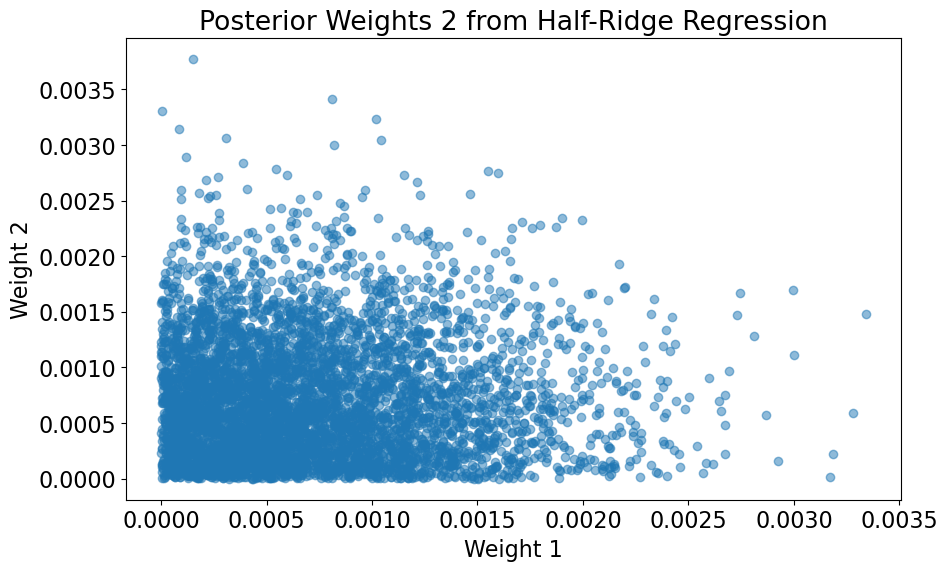

Half ridge regression rejection sampling took 0.19018316268920898 seconds
half-ridge coefficients: {'Column1': 0.0007128582139490656, 'Column2': 0.000708571609713739, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 0.0026366508987303583, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


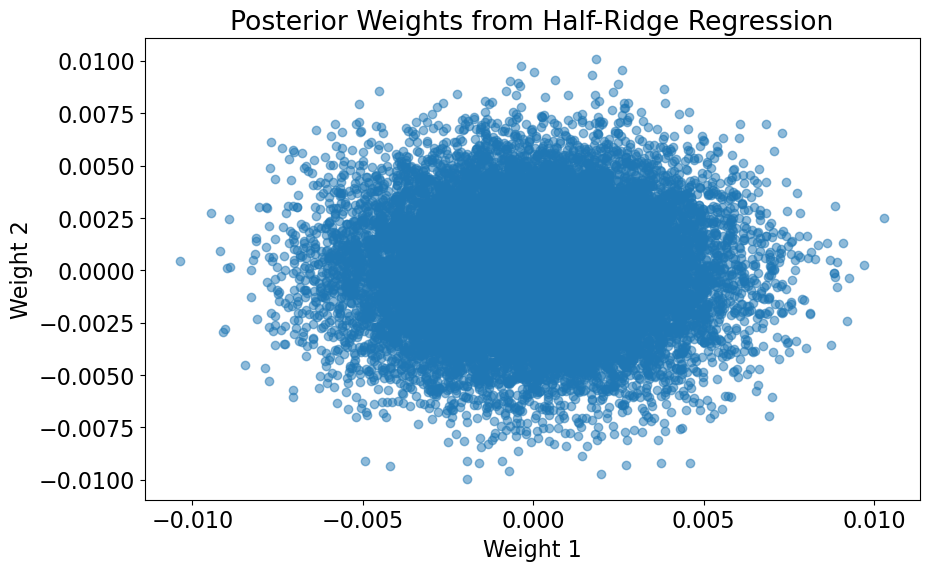

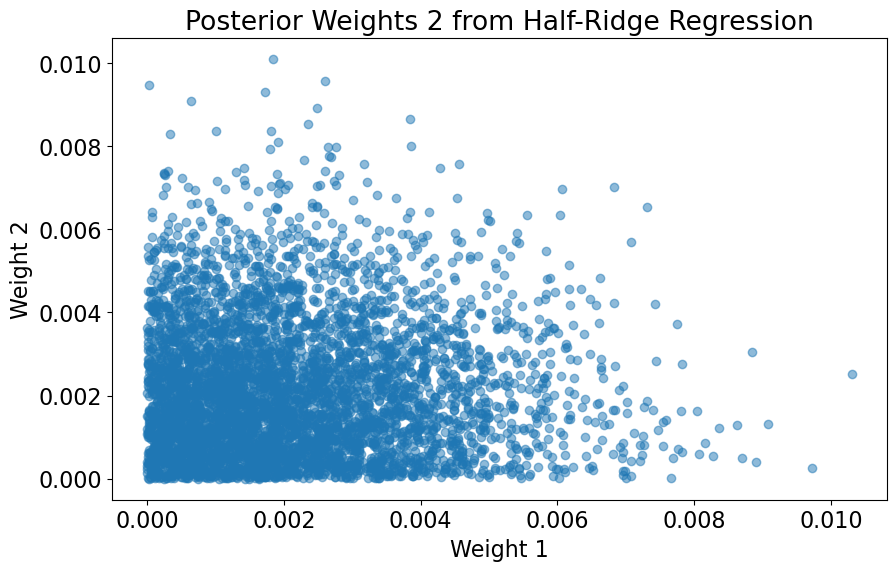

Half ridge regression rejection sampling took 0.18950819969177246 seconds
half-ridge coefficients: {'Column1': 0.002114362379983387, 'Column2': 0.0021159333858855357, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 0.007847599703514606, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


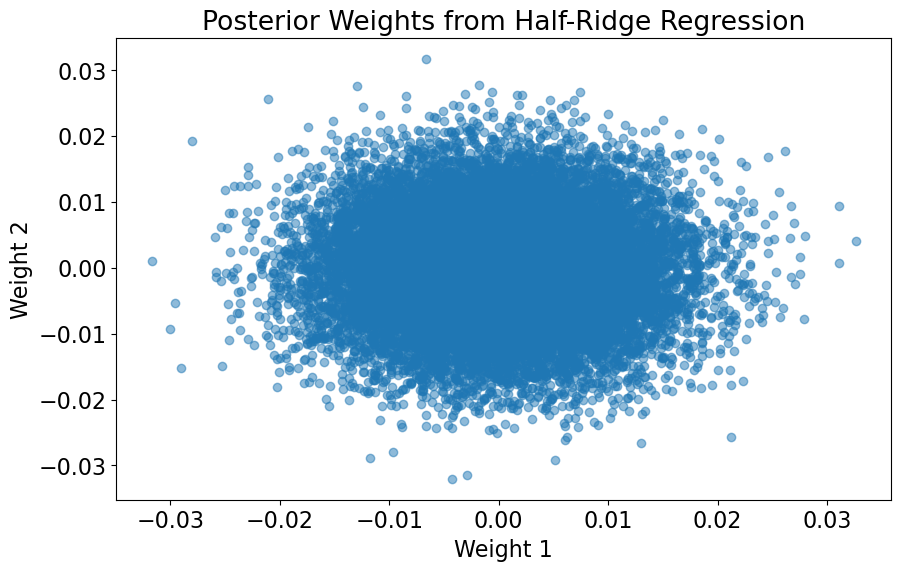

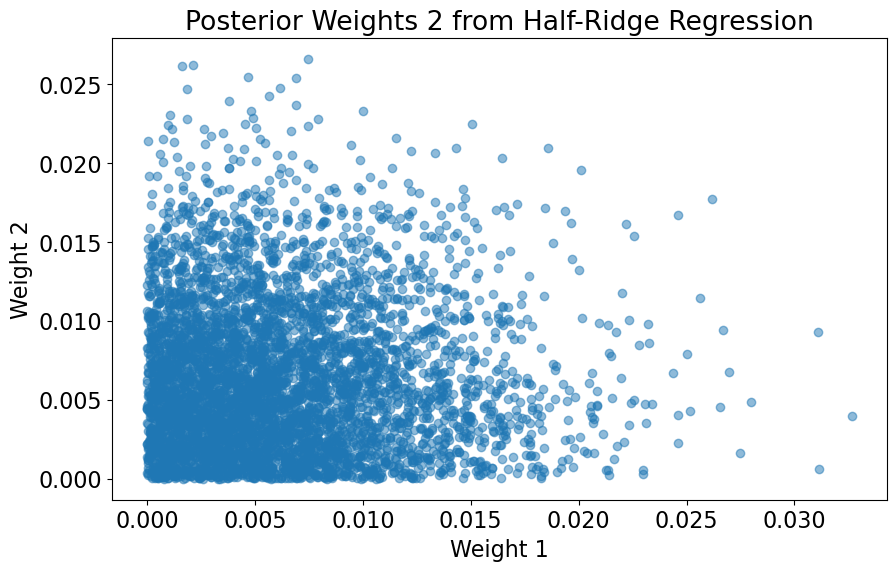

Half ridge regression rejection sampling took 0.1474452018737793 seconds
half-ridge coefficients: {'Column1': 0.006191641584299913, 'Column2': 0.0062977996757429214, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 0.023357214690901212, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


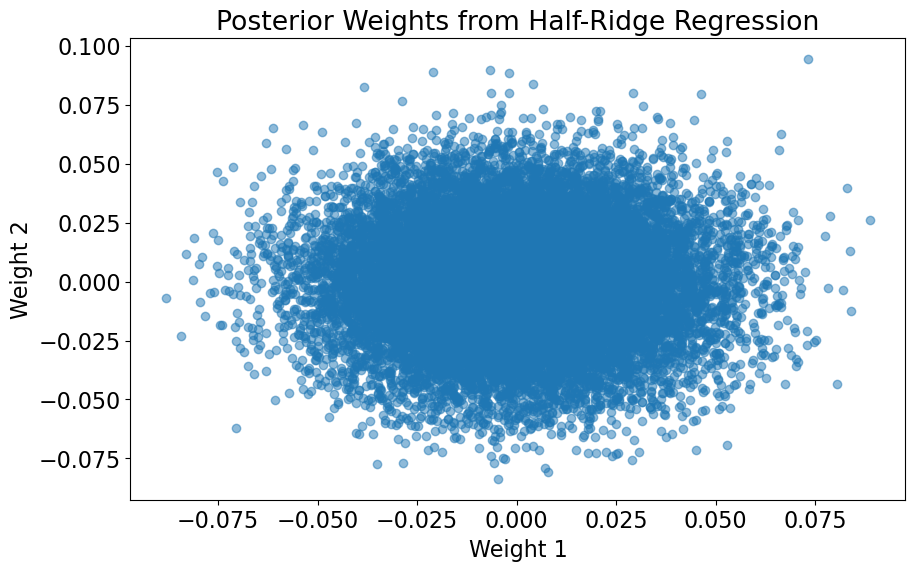

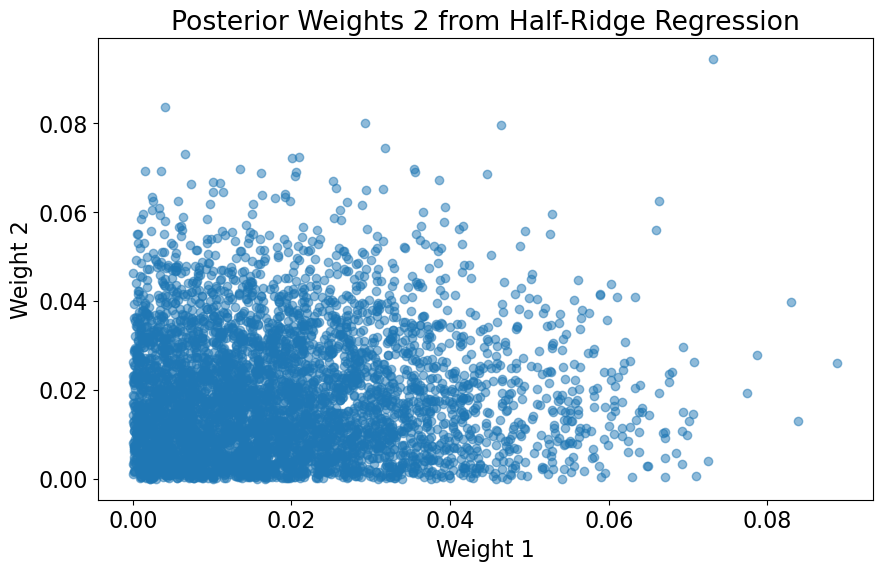

Half ridge regression rejection sampling took 0.18827605247497559 seconds
half-ridge coefficients: {'Column1': 0.01867973970303845, 'Column2': 0.018422749405548246, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 0.06951927961775606, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


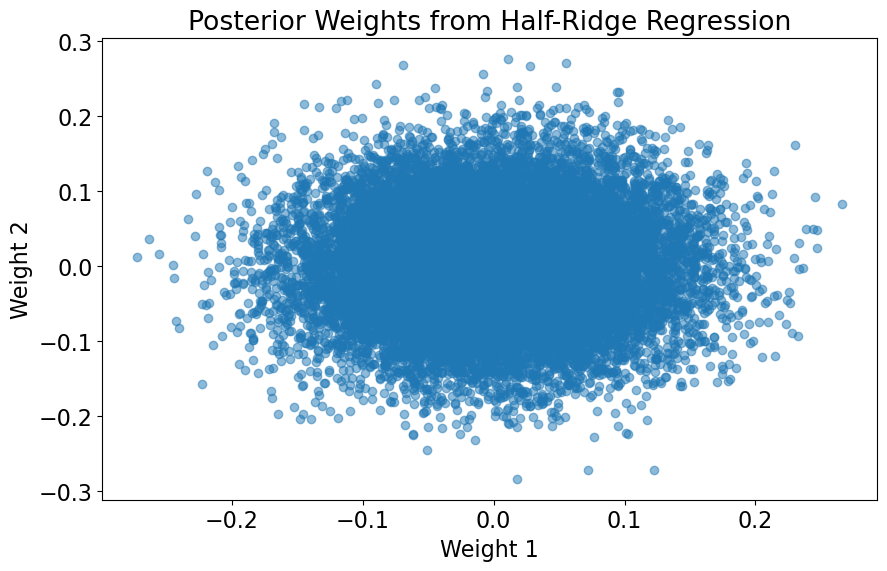

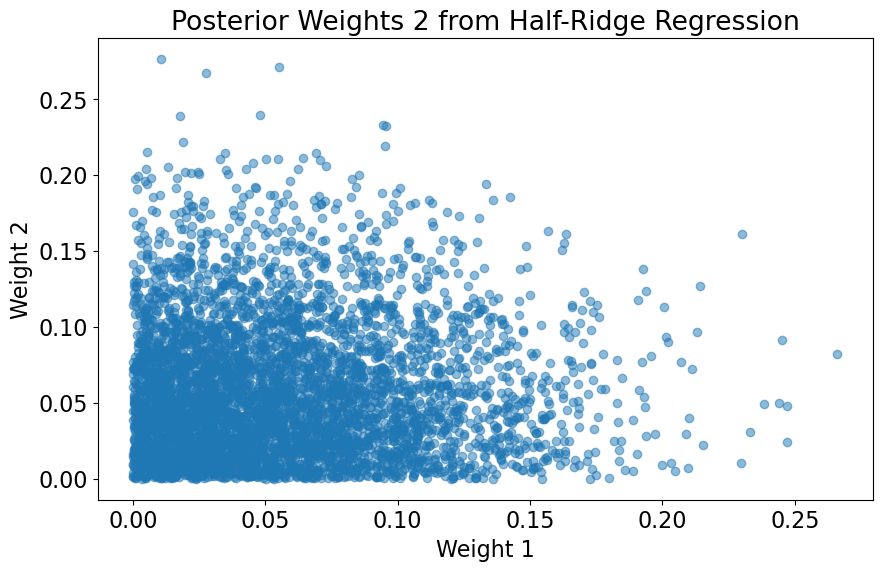

Half ridge regression rejection sampling took 0.18092703819274902 seconds
half-ridge coefficients: {'Column1': 0.05557786361688336, 'Column2': 0.056596333783941334, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 0.2069138081114788, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


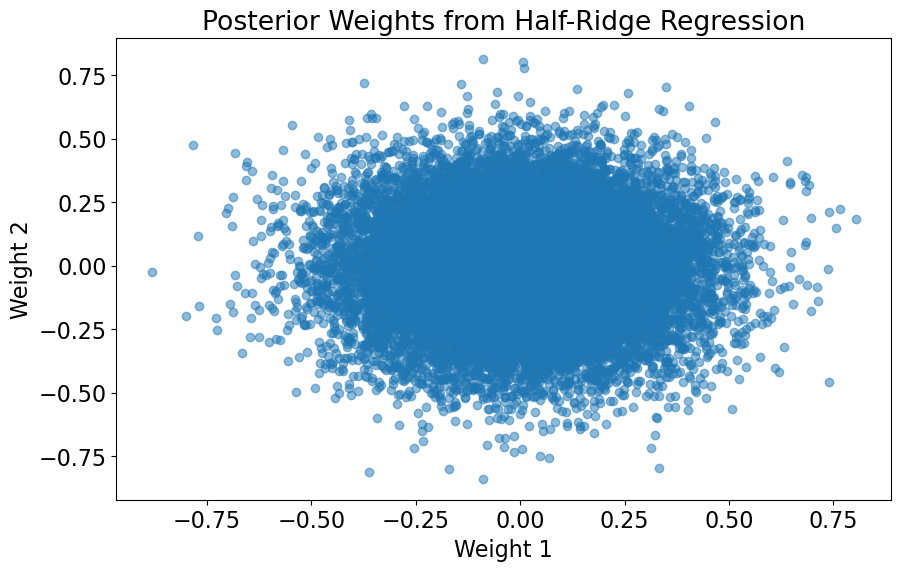

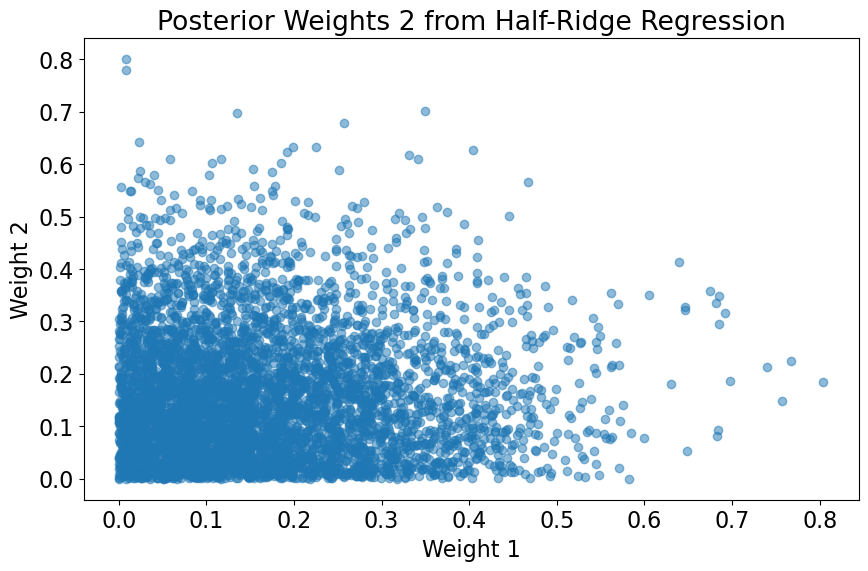

Half ridge regression rejection sampling took 0.18303823471069336 seconds
half-ridge coefficients: {'Column1': 0.16507493388304162, 'Column2': 0.15848938983035174, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 0.615848211066026, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


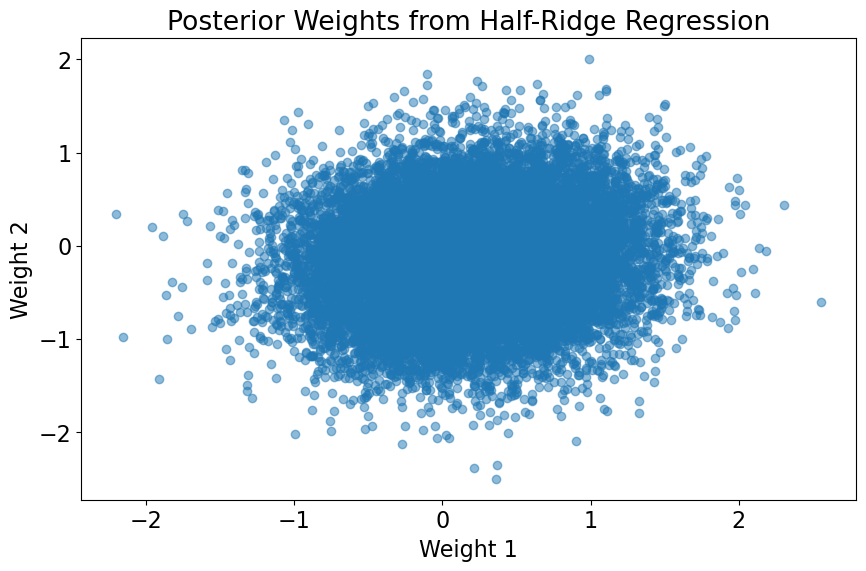

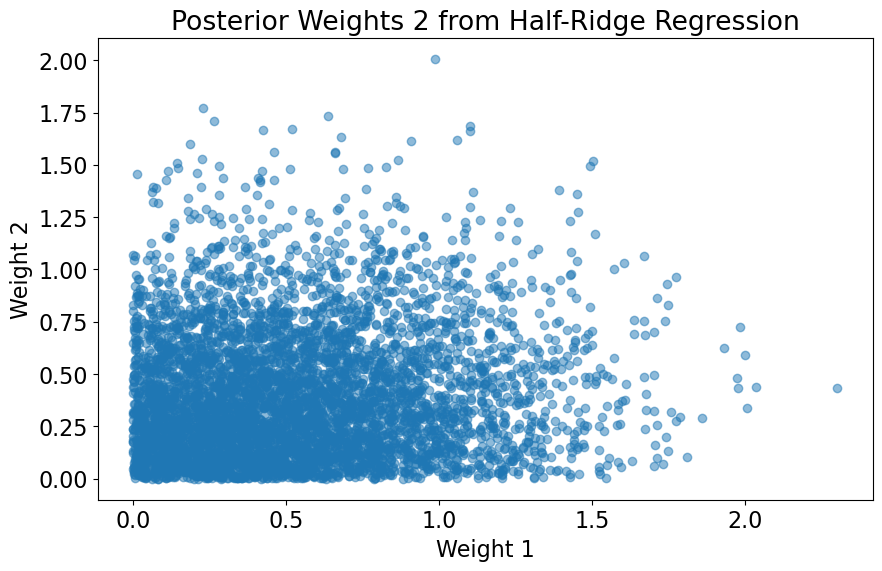

Half ridge regression rejection sampling took 0.1830129623413086 seconds
half-ridge coefficients: {'Column1': 0.5355631648899364, 'Column2': 0.3915185620603837, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 1.8329807108324339, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


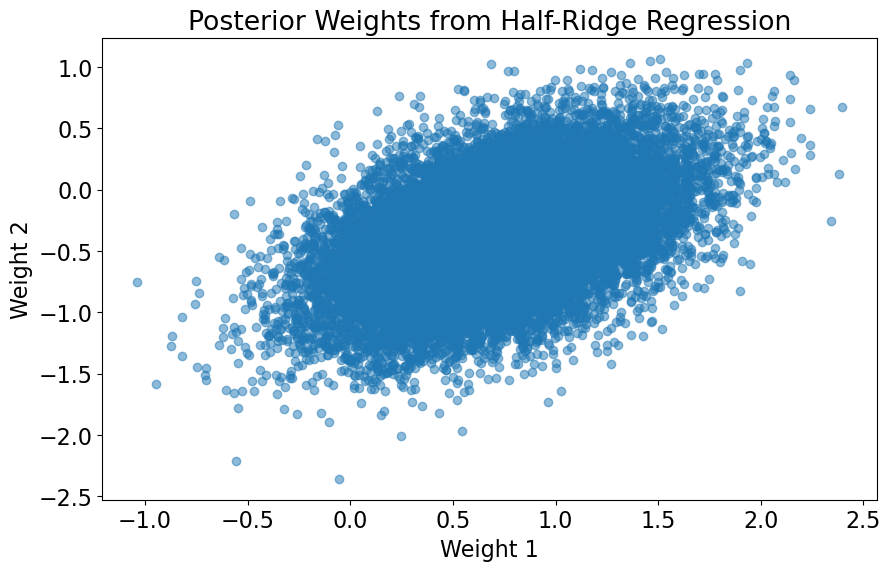

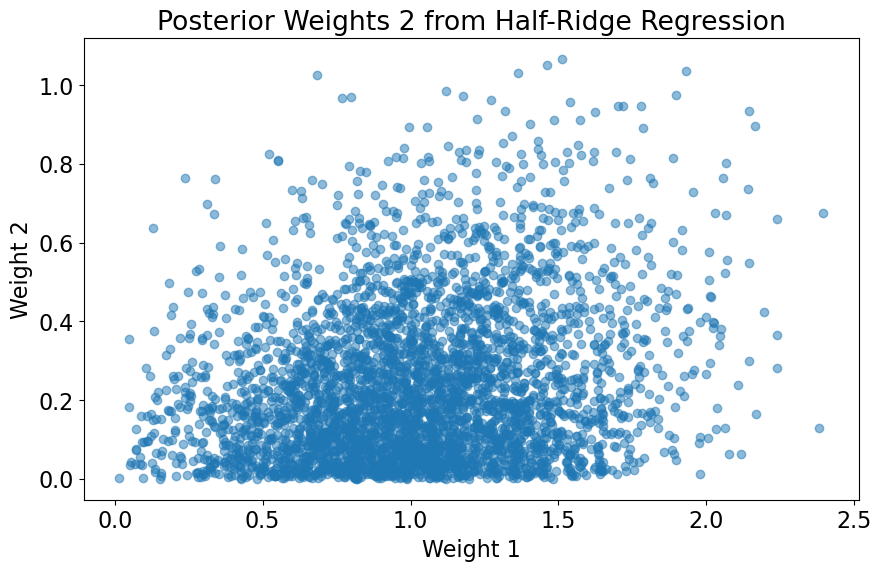

Half ridge regression rejection sampling took 0.22492194175720215 seconds
half-ridge coefficients: {'Column1': 1.0222928610374429, 'Column2': 0.23667465527961332, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 5.455594781168514, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


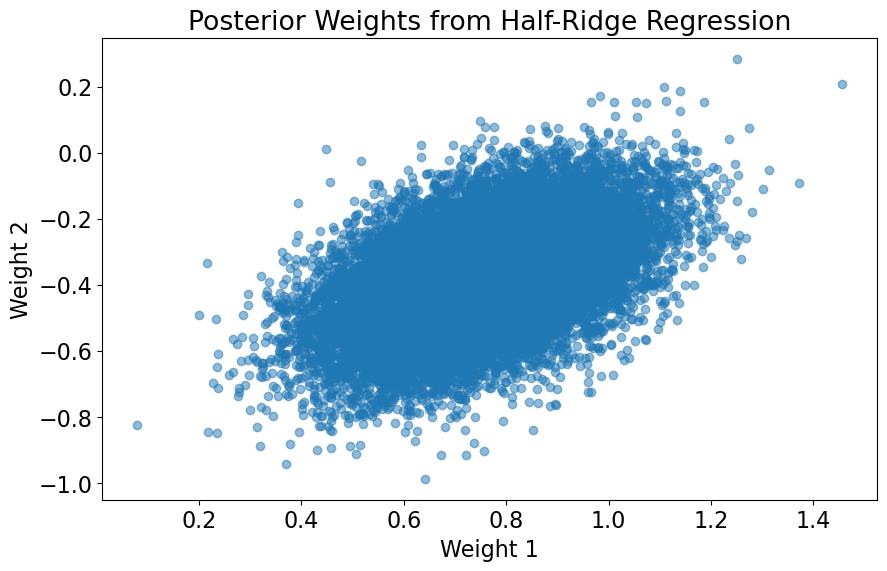

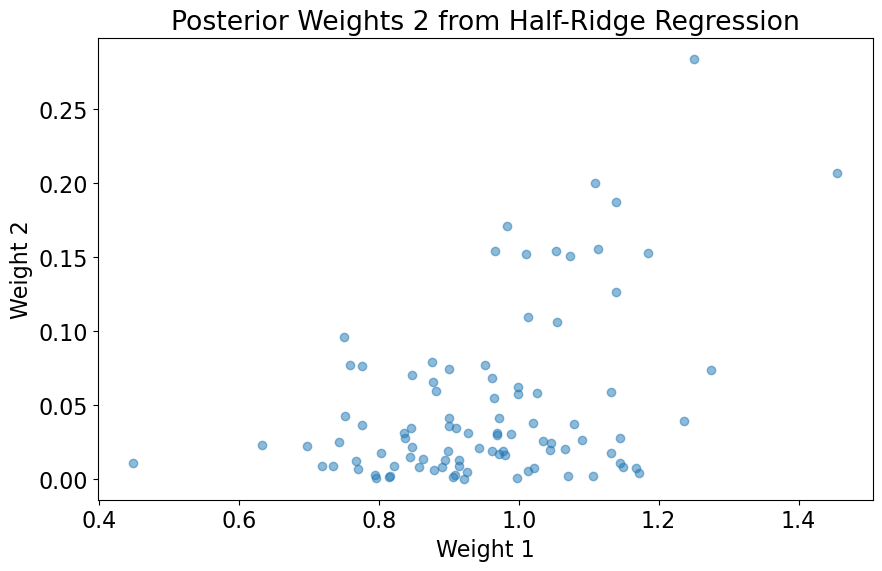

Half ridge regression rejection sampling took 0.1523599624633789 seconds
half-ridge coefficients: {'Column1': 0.9524598152821087, 'Column2': 0.04834481979568376, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 16.23776739188721, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


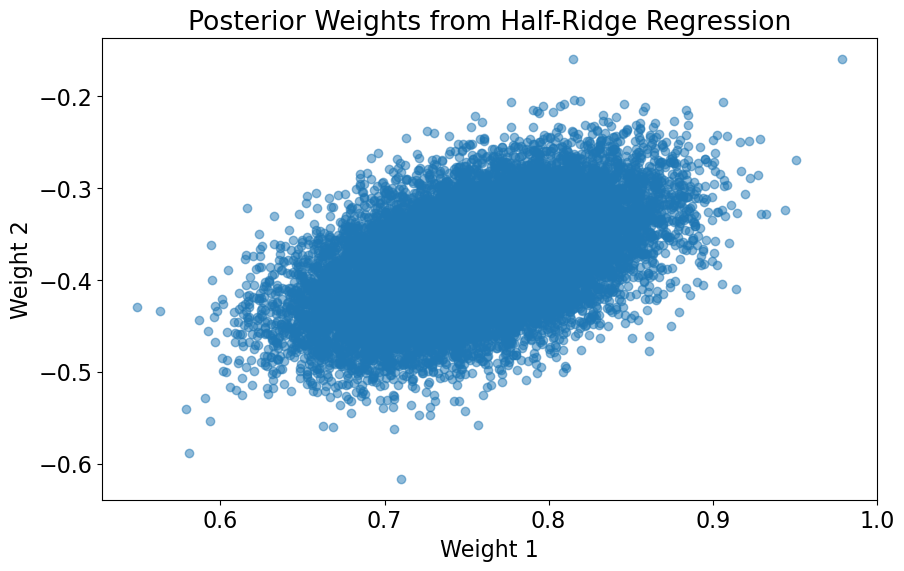

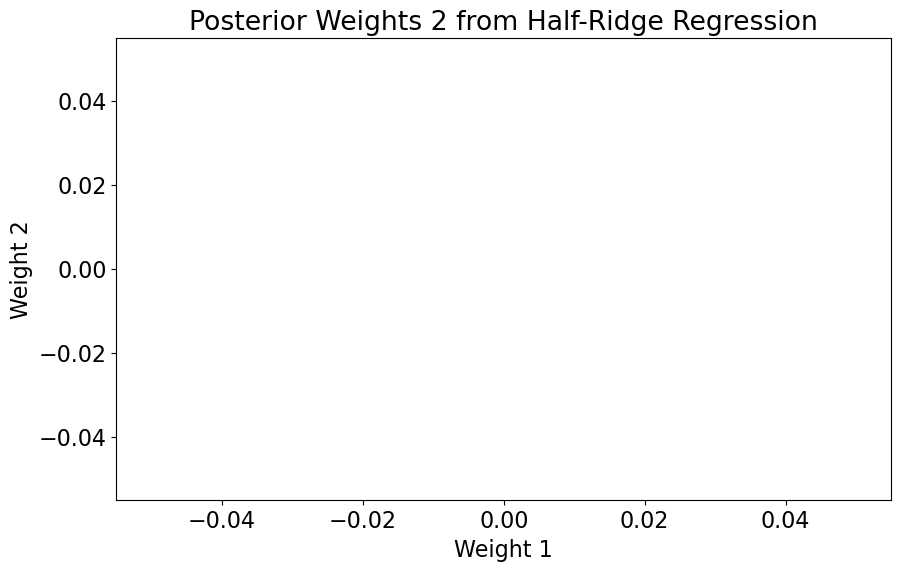

Half ridge regression rejection sampling took 0.15870881080627441 seconds
half-ridge coefficients: {'Column1': 0.755532429485338, 'Column2': -0.3781719286050529, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 48.32930238571752, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


/var/folders/z_/6mbpcrgn0pv8wn8l9tpyq1gh0000gn/T/ipykernel_43894/3308535311.py:80: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


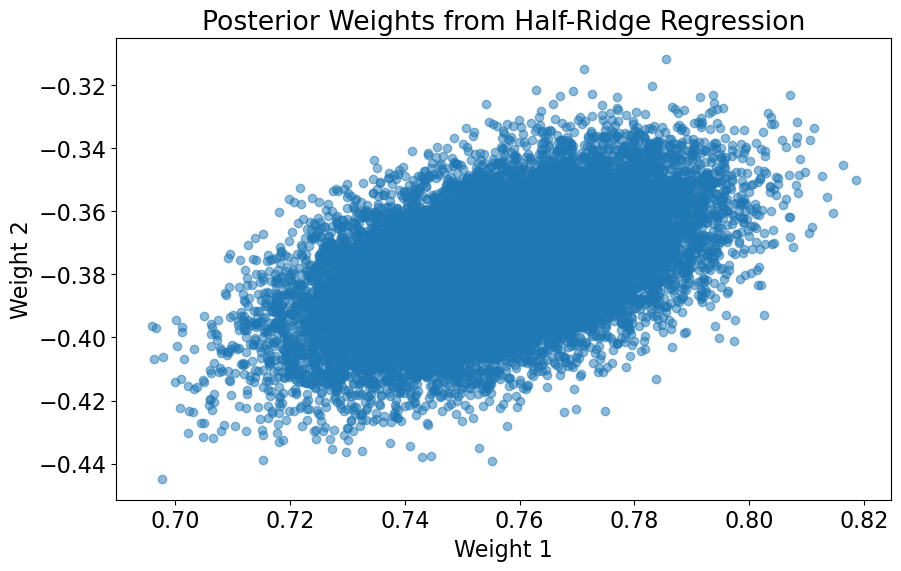

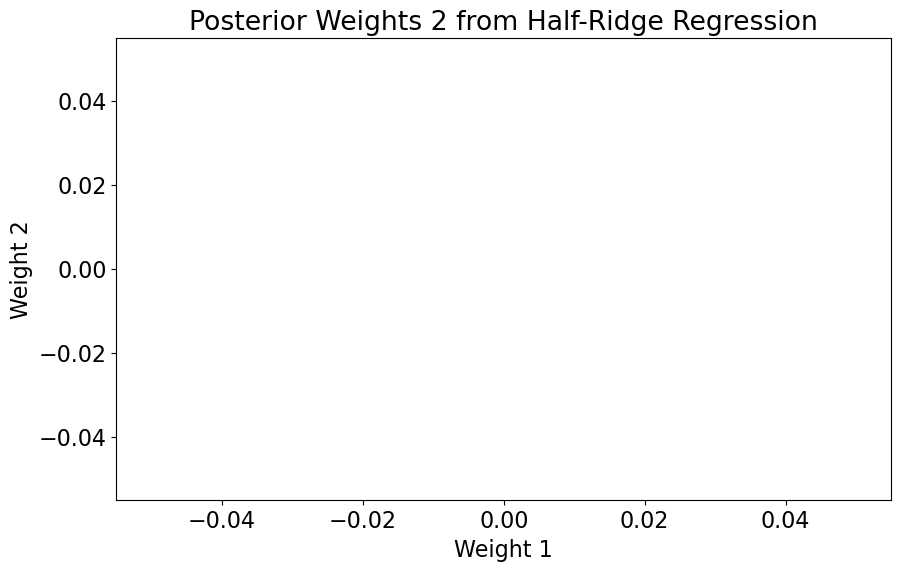

/var/folders/z_/6mbpcrgn0pv8wn8l9tpyq1gh0000gn/T/ipykernel_43894/3308535311.py:80: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Half ridge regression rejection sampling took 0.19033384323120117 seconds
half-ridge coefficients: {'Column1': 0.7559676140676426, 'Column2': -0.37798718166970074, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 143.8449888287663, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


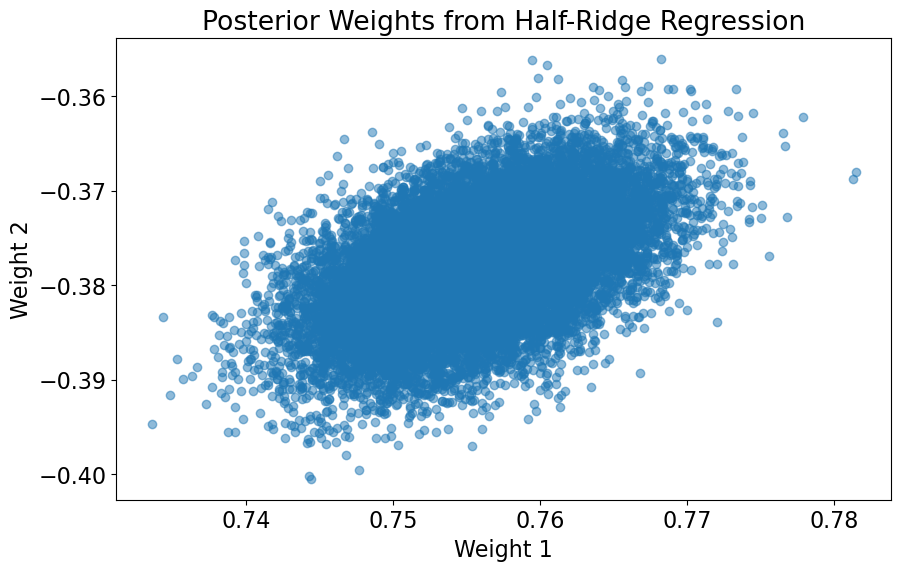

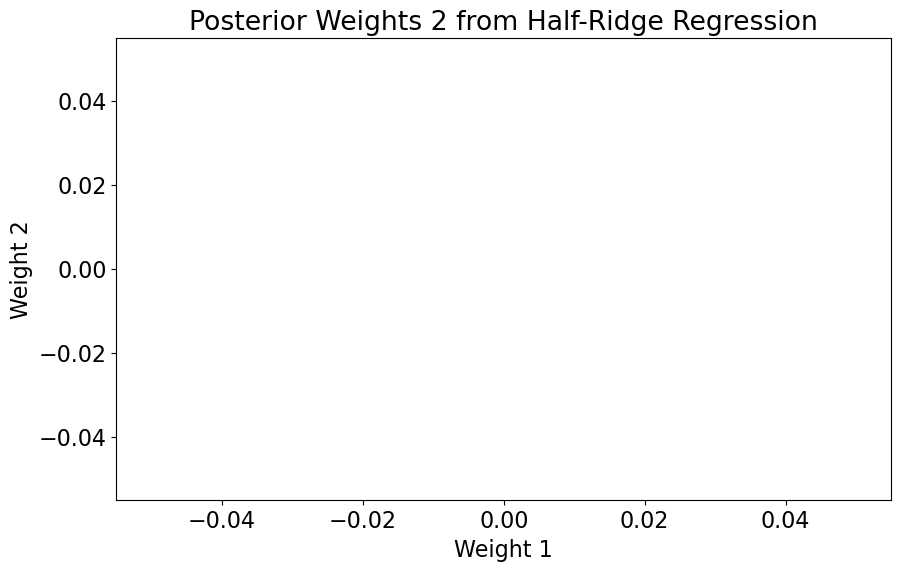

/var/folders/z_/6mbpcrgn0pv8wn8l9tpyq1gh0000gn/T/ipykernel_43894/3308535311.py:80: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Half ridge regression rejection sampling took 0.16785407066345215 seconds
half-ridge coefficients: {'Column1': 0.7559371875572812, 'Column2': -0.37795633956955127, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 428.1332398719387, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


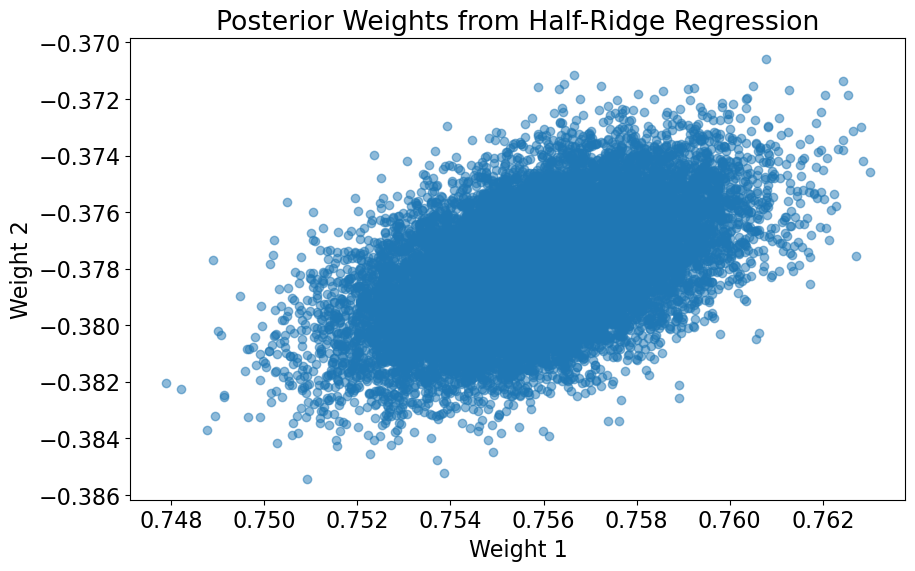

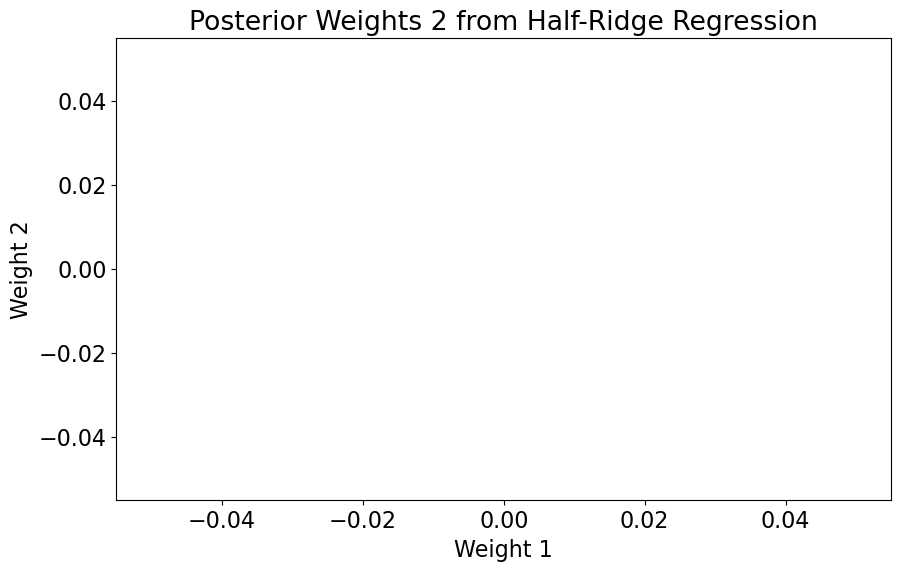

Half ridge regression rejection sampling took 0.2178182601928711 seconds
half-ridge coefficients: {'Column1': 0.7559274179340936, 'Column2': -0.37797943957288754, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 1274.2749857031322, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


/var/folders/z_/6mbpcrgn0pv8wn8l9tpyq1gh0000gn/T/ipykernel_43894/3308535311.py:80: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


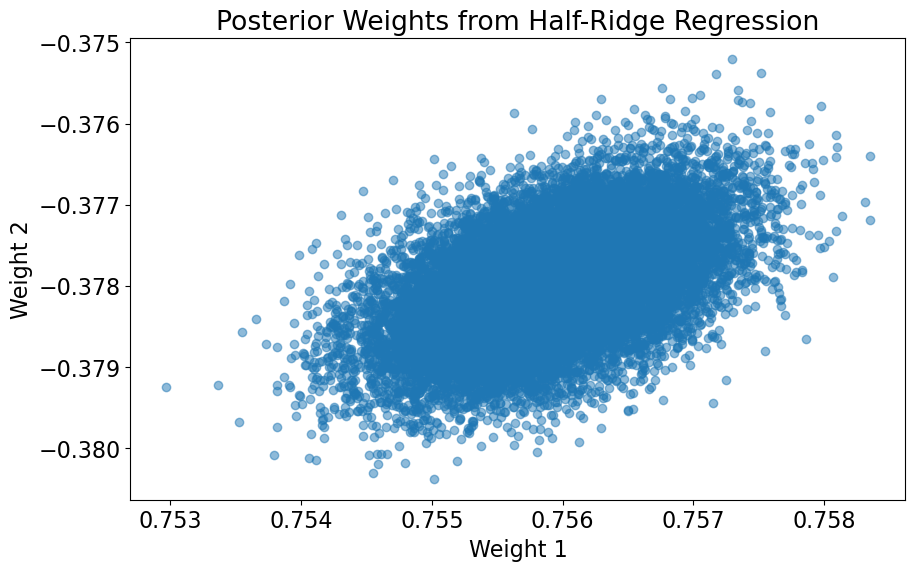

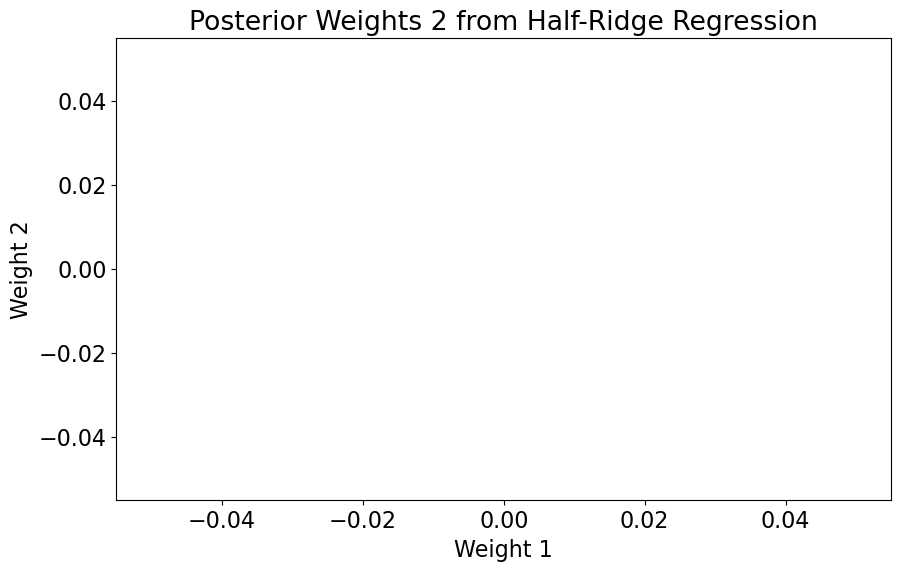

/var/folders/z_/6mbpcrgn0pv8wn8l9tpyq1gh0000gn/T/ipykernel_43894/3308535311.py:80: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Half ridge regression rejection sampling took 0.15367412567138672 seconds
half-ridge coefficients: {'Column1': 0.7559316810145148, 'Column2': -0.3779597749375275, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 3792.690190732246, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


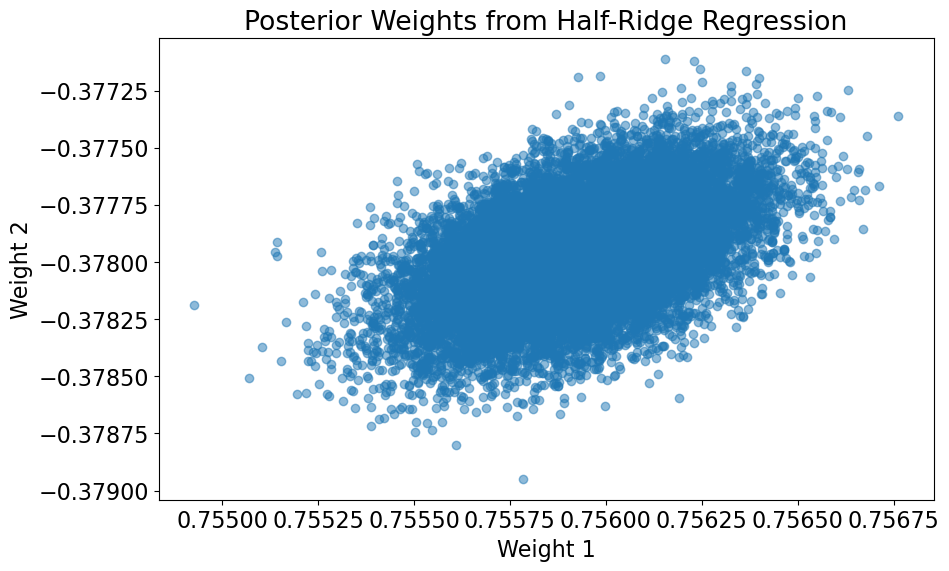

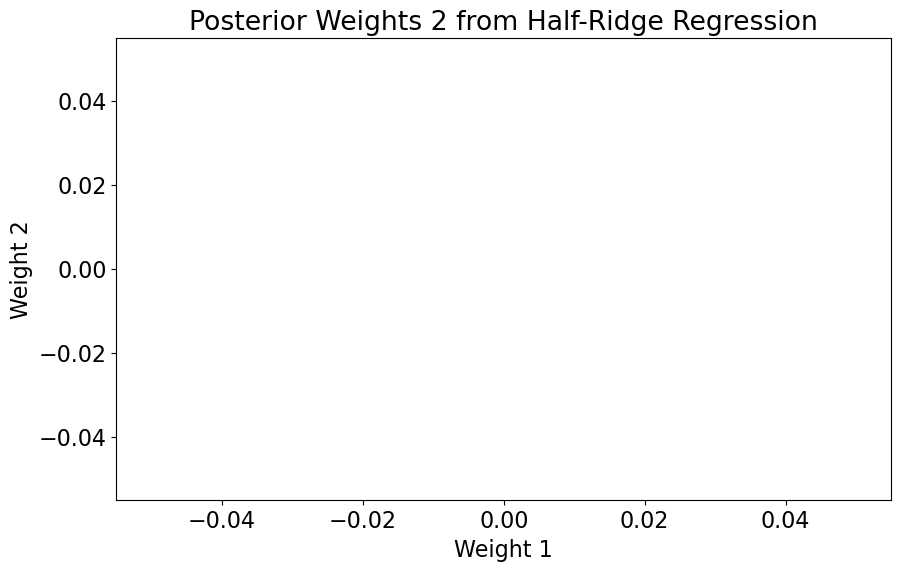

/var/folders/z_/6mbpcrgn0pv8wn8l9tpyq1gh0000gn/T/ipykernel_43894/3308535311.py:80: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Half ridge regression rejection sampling took 0.17160701751708984 seconds
half-ridge coefficients: {'Column1': 0.7559283859759423, 'Column2': -0.3779657726494526, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 11288.378916846883, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


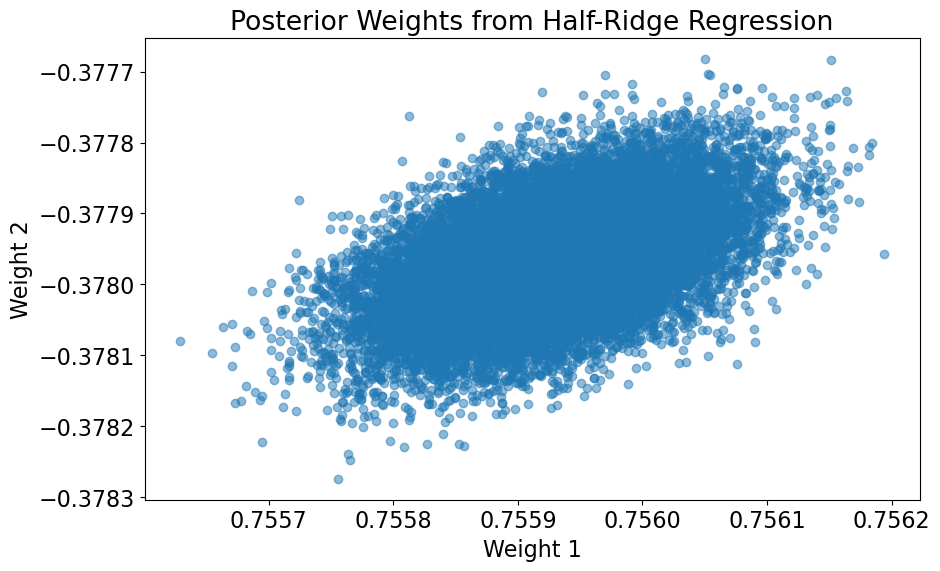

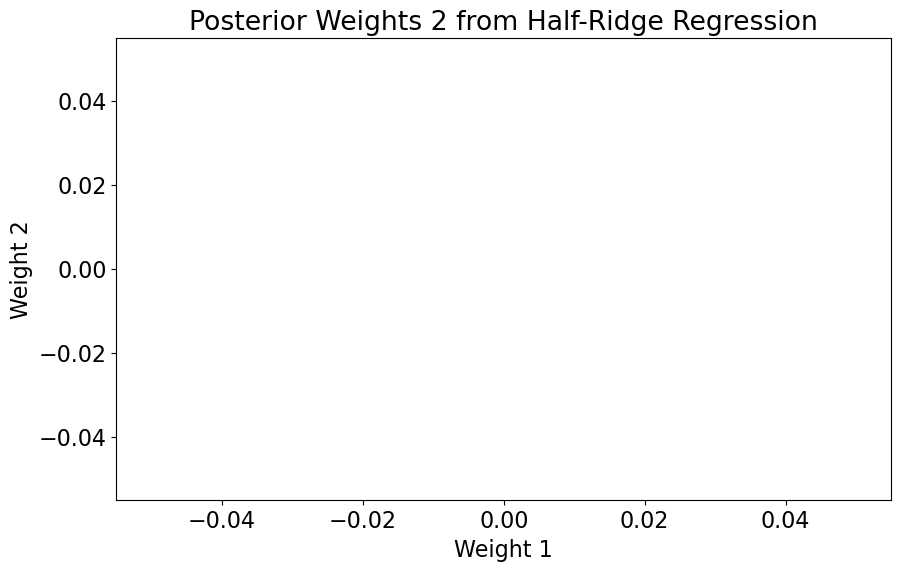

/var/folders/z_/6mbpcrgn0pv8wn8l9tpyq1gh0000gn/T/ipykernel_43894/3308535311.py:80: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Half ridge regression rejection sampling took 0.1948390007019043 seconds
half-ridge coefficients: {'Column1': 0.7559294593465247, 'Column2': -0.3779645709915716, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 33598.18286283774, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


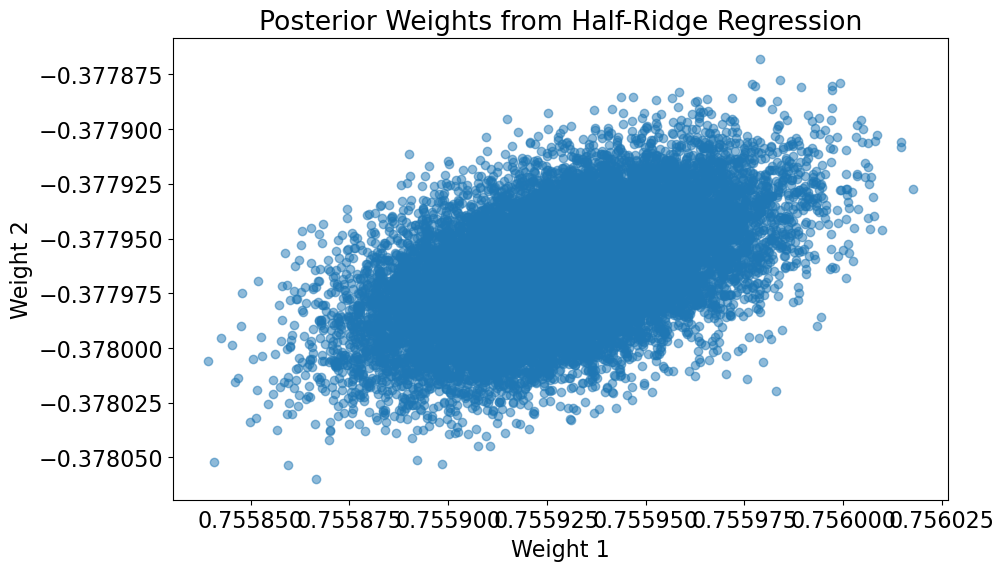

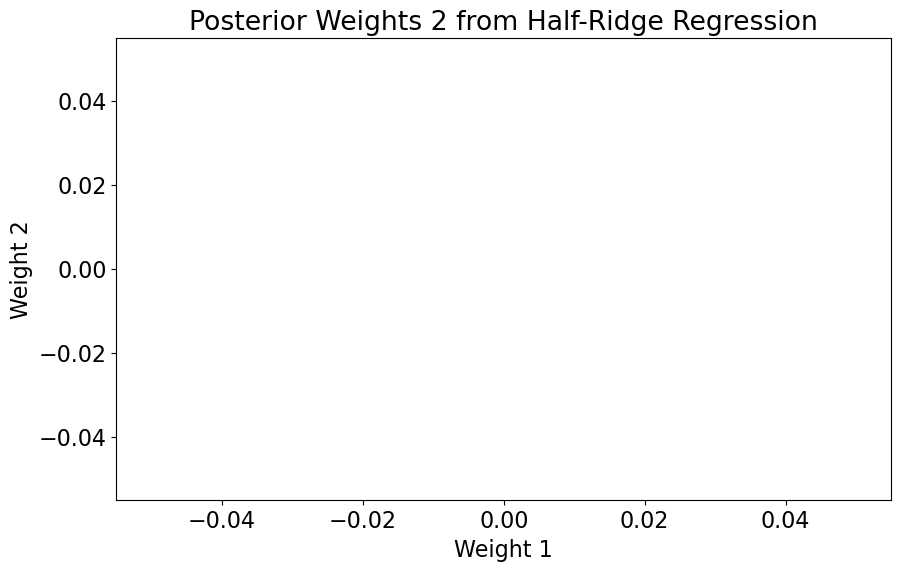

/var/folders/z_/6mbpcrgn0pv8wn8l9tpyq1gh0000gn/T/ipykernel_43894/3308535311.py:80: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Half ridge regression rejection sampling took 0.1676027774810791 seconds
half-ridge coefficients: {'Column1': 0.755928916689084, 'Column2': -0.3779645102286198, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: 100000.0, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...


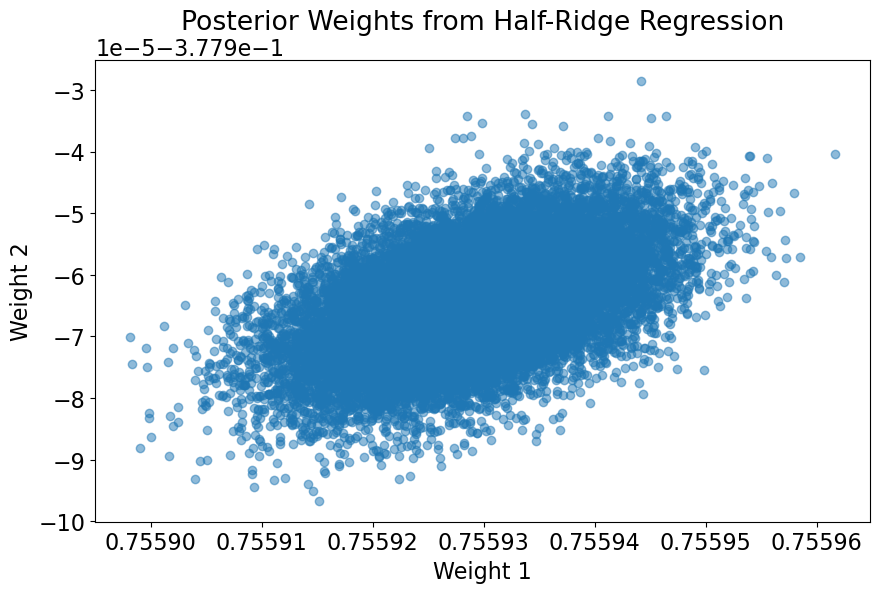

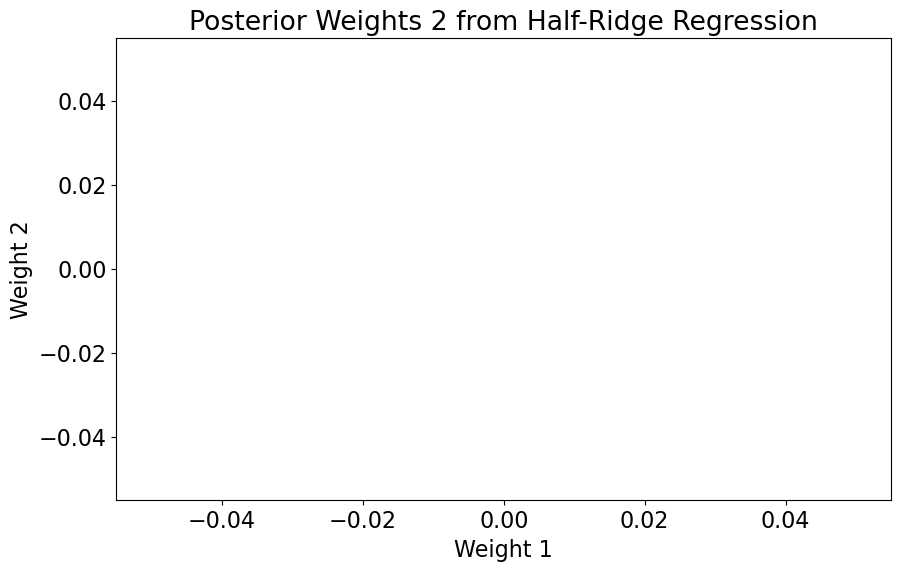

Half ridge regression rejection sampling took 0.1647801399230957 seconds
half-ridge coefficients: {'Column1': 0.7559289463933342, 'Column2': -0.3779644556123807, 'intercept': 0}
binary comparison: 0.481
Training Set Value: 3, Eta: inf, Fold: 0 of range(0, 1)
{'Column1': 0.7559289460184551, 'Column2': -0.37796447300922714}
Running half-ridge regression...
Half ridge regression rejection sampling took 4.0531158447265625e-06 seconds
half-ridge coefficients: {'Column1': 1, 'Column2': 1, 'intercept': 0}
binary comparison: 0.481


/var/folders/z_/6mbpcrgn0pv8wn8l9tpyq1gh0000gn/T/ipykernel_43894/3308535311.py:80: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


In [28]:
# Load the ICU dataset, normalize the data, and split into training, validation, and test sets

# Loop over each dataset, loaded from file and formatted
for dataset in uci_datasets:
    model = Model()
    model.import_from_file('uci_ml_datasets/ucirepo_' + str(dataset) + '.csv')
    model.format_data()
    training_set_values = model.set_up_training_values(training_set_sizes, 1.1)

    # Check if a file exists for the dataset in the model_results folder
    if os.path.isfile(f"model_results/ucirepo_{dataset}.csv") and not overwrite_model:
        print(f"Model already exists for dataset {dataset}. Skipping...")
        continue

    # Print the training set values for this dataset
    print(f"Training Set Values: {training_set_values}")
    
    # Initialize the comparison results
    binary_comparisons = {}

    # Determine the signs of the coefficients using OLS (all data)
    #if ols_use_all_data:
    #    ols_coefficients = model.get_ols_coefficients(True)
    #    weight_signs = np.sign(list(ols_coefficients.values()))

    # loop over the training set values
    for training_set_index, training_set_value in enumerate(training_set_values):

        # Generate cross-validation indices
        cv = model.cv_indexing(cv_folds, training_set_value)

        # Initialize the comparison results for this training set value
        binary_comparisons[training_set_value] = {}

        # Vary eta values from 10^-4 to 10^5, including 0 and inf, and loop over them
        etas = np.logspace(-4, 5, num=num_etas)
        etas = np.insert(etas, 0, 0)
        etas = np.append(etas, np.inf)
        for eta in etas:

            # Initialize the comparison results for this eta
            binary_comparisons[training_set_value][eta] = []

            # Crossvalidate over the folds for a specific eta
            for i in range(cv_folds):

                # Print info about this iteration
                print(f"Training Set Value: {training_set_value}, Eta: {eta}, Fold: {i} of {range(cv_folds)}")

                # Get training and test indices for the i-th fold
                train_indices = np.where(cv[i] == 1)[0]
                test_indices = np.where(cv[i] == 0)[0]
                
                # Split the data
                X_train, X_test = model.X.iloc[train_indices], model.X.iloc[test_indices]
                y_train, y_test = model.y.iloc[train_indices], model.y.iloc[test_indices]

                # Get OLS coefficients for the training data
                ols_coefficients = model.get_ols_coefficients(False, X_train, y_train)
                print(ols_coefficients)
                ols_coefficients = material_properties = {
                    'Column1': 1,
                    'Column2': 1
                }

                # Determine the signs of the coefficients using OLS on only the training data
                #if not ols_use_all_data:
                #    weight_signs = np.sign(list(ols_coefficients.values()))
                weight_signs = np.sign(list(ols_coefficients.values()))

                # Run the half ridge regression with mcmc
                #half_ridge_trace = half_ridge(X_train, y_train, model.ols_coefficients, prior_eta=eta)
                #var_dict = {}
                #for variable in half_ridge_trace.posterior:
                #    var_dict[variable] = half_ridge_trace.posterior[variable].values.flatten()
                # Results into a dataframe
                #var_weights = pd.DataFrame(var_dict)
                # Means for all the weights
                #var_means_array = var_weights.mean(axis=0)
                # Convert the dataframe var_means_array to a dictionary with the column names as keys
                #half_ridge_coefficients = {col: var_means_array[col] for col in var_weights.columns}
                
                # Run the half ridge regression with rejection sampling
                start_time = time.time()
                half_ridge_coefficients = half_ridge_rejection_sampling(weight_signs, ols_coefficients, X_train, y_train, eta, chain_lengths[training_set_index])
                end_time = time.time()
                duration = end_time - start_time
                print(f"Half ridge regression rejection sampling took {duration} seconds")

                # Calculate the binary comparisons for the models
                sorted_half_ridge_coefficients = {k: half_ridge_coefficients[k] for k in sorted(half_ridge_coefficients)}
                sorted_half_ridge_coefficients['intercept'] = 0
                print(f"half-ridge coefficients: {sorted_half_ridge_coefficients}")
                #binary_comparison = calculate_binary_comparison(sorted_half_ridge_coefficients, X_test, y_test)
                #binary_comparisons[training_set_value][eta].append(binary_comparison)
                print(f"binary comparison: {binary_comparison}")

    
    with open('model_results/ucirepo_' + str(dataset) + '.csv', 'wb') as file:
        pickle.dump(binary_comparisons, file)
